In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

Populating the interactive namespace from numpy and matplotlib


In [62]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]
# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

# 962 rows, 39 features
data.shape

(19466, 53)

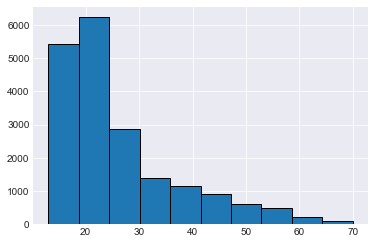

In [63]:
data['age'].hist(edgecolor='black')

In [65]:
women = data[data.gender == 'woman']
men = data[data.gender == 'man']

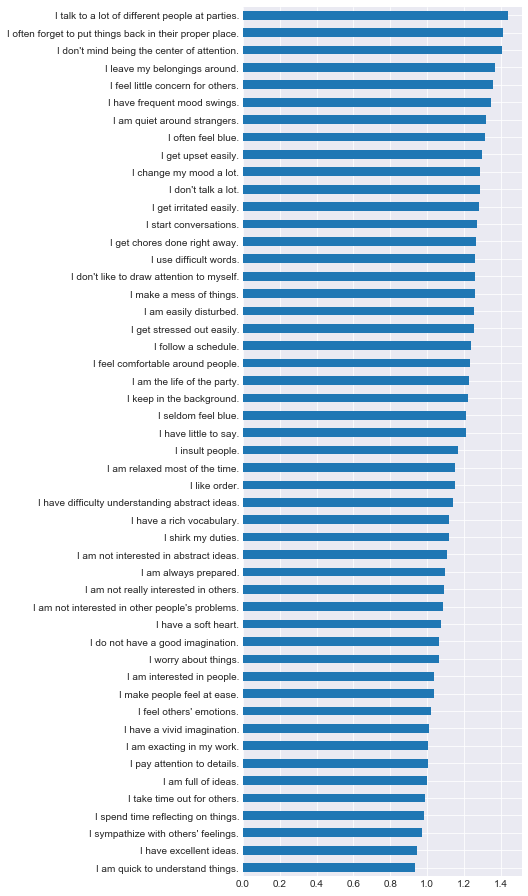

In [66]:
women.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

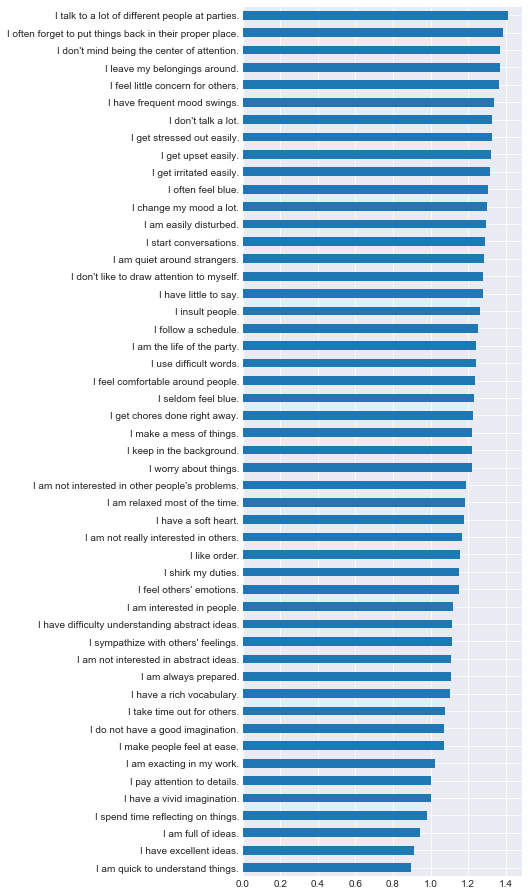

In [67]:
men.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

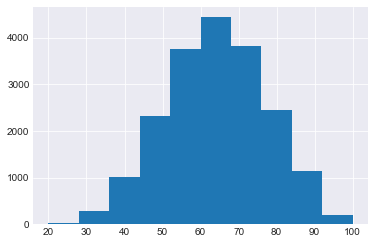

In [68]:
data['Conscientiousness'] =\
(data['I am always prepared.'] +
data['I get chores done right away.'] +
data['I like order.'] +
data['I follow a schedule.'] +
data['I am exacting in my work.'] +
(6 - data['I leave my belongings around.']) +
(6 - data['I pay attention to details.']) +
(6 - data['I make a mess of things.']) +
(6 - data['I often forget to put things back in their proper place.']) +
(6 - data['I shirk my duties.']))/.5

data['Conscientiousness'].hist()

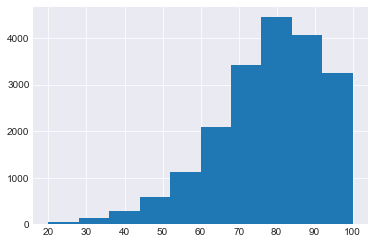

In [69]:
data['Agreeableness'] =\
(data['I take time out for others.'] +
data['I am interested in people.'] +
data["I sympathize with others' feelings."] +
data['I have a soft heart.'] +
data['I make people feel at ease.'] +
data["I feel others' emotions."] +
(6 - data["I am not interested in other people\'s problems."]) +
(6 - data["I insult people."]) +
(6 - data["I feel little concern for others."]) +
(6 - data['I am not really interested in others.']))/.5

data['Agreeableness'].hist()

In [70]:
data.columns

Index(['age', 'gender', 'country', 'I am the life of the party.',
       'I don't talk a lot.', 'I feel comfortable around people.',
       'I keep in the background.', 'I start conversations.',
       'I have little to say.',
       'I talk to a lot of different people at parties.',
       'I don't like to draw attention to myself.',
       'I don't mind being the center of attention.',
       'I am quiet around strangers.', 'I get stressed out easily.',
       'I am relaxed most of the time.', 'I worry about things.',
       'I seldom feel blue.', 'I am easily disturbed.', 'I get upset easily.',
       'I change my mood a lot.', 'I have frequent mood swings.',
       'I get irritated easily.', 'I often feel blue.',
       'I feel little concern for others.', 'I am interested in people.',
       'I insult people.', 'I sympathize with others' feelings.',
       'I am not interested in other people's problems.',
       'I have a soft heart.', 'I am not really interested in others.',
   

## Women

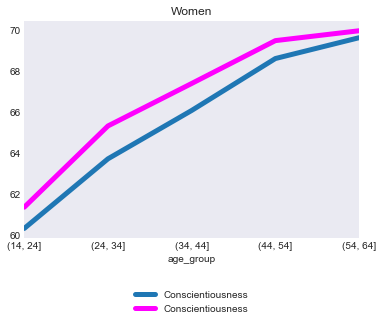

In [76]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

men_c = data[data['gender'] == 'man'].groupby('age_group').mean()
women_c = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_c['Conscientiousness'].plot(linewidth=5)
women_c['Conscientiousness'].plot(linewidth=5, color='magenta')

plt.title('Women')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

Do women really become less affiliative?

In [11]:
from scipy.stats import ttest_ind

women_age_30 = data[(data.gender == 0) & (data.age_group.astype(str) == '(25, 35]')]['affiliative'].dropna()
women_age_60 = data[(data.gender == 0) & (data.age_group.astype(str) == '(55, 65]')]['affiliative'].dropna()

ttest_ind(women_age_30, women_age_60)

Ttest_indResult(statistic=2.4633732240448754, pvalue=0.016189277650691596)

That's a pretty low p-value. From this data, we would say it's pretty likely -- although more rigorous studies have shown that people actually become more self-effacing and affiliative as they get older.

Ah well... lies, damn lies, and statistics.

# Predicting age

For the machine learning tasks, I'm just going to use cross_val_score and not bother with train/test sets. This project is too casual for that!

In [12]:
from xgboost import XGBRegressor

x = data.drop(['age', 'age_group'], axis=1)
y = data['age']

clf = XGBRegressor()
params = {'max_depth': [2,3],
         'n_estimators': np.arange(10,50,10),
         'reg_lambda': np.arange(1.0, 1.31, .1)}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='neg_mean_absolute_error').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='neg_mean_absolute_error')

print(clf, '\n')
print('Predicts the age within {} years'.format(round(-cv.mean(), 1)))
print('Std Dev:   ', cv.std())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=0,
       silent=True, subsample=1) 

Predicts the age within 8.0 years
Std Dev:    0.963282544819


# Predicting gender

In [13]:
from xgboost import XGBClassifier

x = data.drop(['gender', 'age_group'], axis=1)
y = data['gender']

clf = XGBClassifier()
params = {'max_depth': [2,3,4,5],
         'n_estimators': np.arange(10,50,10),
         'reg_lambda': np.arange(1.0, 1.91, .1)}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean ROC-AUC:', cv.mean())
print('Std Dev:     ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.1000000000000001, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean ROC-AUC: 0.626830396338
Std Dev:      0.0413246374777


The model does an okay, but not great, job of predicting gender. Male and female humor doesn't differ *that* much.